## Test CatPred, Temberture, and EpHod on _Burkholderia_ Lipase Dataset


Using these substrates:

| Compound                     | SMILES                                   |
|------------------------------|------------------------------------------|
| p-Nitrophenyl acetate (C2)   | CC(=O)Oc1ccc(cc1)[N+](=O)[O-]           |
| p-Nitrophenyl butyrate (C4)  | CCCC(=O)Oc1ccc(cc1)[N+](=O)[O-]         |
| p-Nitrophenyl caprylate (C8) | CCCCCCCC(=O)Oc1ccc(cc1)[N+](=O)[O-]     |
| p-Nitrophenyl decanoate (C10)| CCCCCCCCCC(=O)Oc1ccc(cc1)[N+](=O)[O-]   |
| p-Nitrophenyl laurate (C12)  | CCCCCCCCCCCC(=O)Oc1ccc(cc1)[N+](=O)[O-] |
| p-Nitrophenyl myristate (C14)| CCCCCCCCCCCCCC(=O)Oc1ccc(cc1)[N+](=O)[O-]|
| p-Nitrophenyl palmitate (C16)| CCCCCCCCCCCCCCCC(=O)Oc1ccc(cc1)[N+](=O)[O-]|


In [ ]:
from proteus.fitness_predictors import (
    EpHodPredictor,
    ThermostabilityPredictor,
    KineticPredictor
)

catpred_weights_dir = "/home/ec2-user/SageMaker/CatPred/weights"
ephod_weights_dir = "/home/ec2-user/SageMaker/models"

substrates = {
    "p-Nitrophenyl acetate (C2)": "CC(=O)Oc1ccc(cc1)[N+](=O)[O-]",
    "p-Nitrophenyl butyrate (C4)": "CCCC(=O)Oc1ccc(cc1)[N+](=O)[O-]",
    "p-Nitrophenyl caproate (C6)": "CCCCCC(=O)Oc1ccc(cc1)[N+](=O)[O-]",
    "p-Nitrophenyl caprylate (C8)": "CCCCCCCC(=O)Oc1ccc(cc1)[N+](=O)[O-]",
    "p-Nitrophenyl decanoate (C10)": "CCCCCCCCCC(=O)Oc1ccc(cc1)[N+](=O)[O-]",
    "p-Nitrophenyl laurate (C12)": "CCCCCCCCCCCC(=O)Oc1ccc(cc1)[N+](=O)[O-]",
    "p-Nitrophenyl myristate (C14)": "CCCCCCCCCCCCCC(=O)Oc1ccc(cc1)[N+](=O)[O-]",
    "p-Nitrophenyl palmitate (C16)": "CCCCCCCCCCCCCCCC(=O)Oc1ccc(cc1)[N+](=O)[O-]"
}

lipase_sequences = {
    "Burkholderia_ubonensis": "MARSMRSRVVAGAVACAMSAAPFAGMTALATVATTRAAVAATAPADDYATTRYPIILVHGLTGTDKYAGVLDYFYGIQQDLQQHGATVYVANLSGYQSDDGPDGRGEQLLAQVKQVLAQTGAAKVNLVGHSQGGLSSRYVAAVAPELVASVTTIGTPHRGSEFADFVQGVLAYDPTGLSSTVIAAFVNVFGMLTSSTHNTNQDALAALQTLTTARAATYNQNFPSAGLGAPGSCQSGAPTETVGGNTHLLYSWAGTAIQPTFSALGVTGAKDTSTIPVADPANALDVSTLALLGSGTVMINRGAGENDGVVSKCSALFGQVLSTSYKWNHVDEINQLLGVRGAYAEDPVAVIRTHANRLKLAGV",
    "Bacillus_stratosphericus": "MKVICFKKKSLQILVALALVIGSMAFIQPKEVKAAAHNPVVMVHGMGGASYNFASIKRYLVSQGWDQNQLFAIDFIDKTGNNLNNGPRLSRFVKDVLAKTGAKKVDIVAHSMGGANTLYYIKNLDGGDKIENVVTLGGANGLVSLRALPGTDPNQKILYTSVYSSADLIVVNSLSRLIGARNVLIHGVGHIGLLTSSQVKGYVKEGLNGGGQNTN",
    "Acinetobacter_sp_XMZ26": "MTQQSSMHYRLSEEMQSLVYWSSIYSPADDDIDSIRAAYDAMCLHYTLPRDGTVNIEDKTVPQLNHPVNVRLYSPLGEAPATGWPCILYLHGGGWMVGNLDSHEFITRYLCRDLNVAVLSVDYRLTPEHHFPAAYEDCETVYHWLYQHGLQWKINPNQIVLMGDSAGGNLAAALAVQLQHTGAQACGLAMIYPCLSSGFDTASCQQQADAPLLSLADMHDYLQAYAPNTSDWQDLRLSPLLAQDFSDMPRSFIAVAEYDPLSDDGRIFADKLKQANIATEFYLGKGLLHGSLRLVRDCPVVQDLYQRMLSSLKPMFN"
}
sequences = list(lipase_sequences.values())
device = "cuda"

kcat_predictors = {}
km_predictors = {}

for substrate_name, smiles in substrates.items():
    kcat_predictors[substrate_name] = KineticPredictor(
        substrate_smiles=smiles,
        substrate_name=substrate_name,
        parameter="kcat",
        device=device,
        docker_image="ghcr.io/new-atlantis-labs/catpred:latest",
        weights_dir=catpred_weights_dir
    )
    
    km_predictors[substrate_name] = KineticPredictor(
        substrate_smiles=smiles,
        substrate_name=substrate_name,
        parameter="km",
        device=device,
        docker_image="ghcr.io/new-atlantis-labs/catpred:latest",
        weights_dir=catpred_weights_dir
    )
ep_predictor = EpHodPredictor(
    weight=1.0,
    device=device,
    docker_image="ghcr.io/new-atlantis-labs/ephod:latest",
    weights_dir=ephod_weights_dir,
    verbose=True
)

temp_predictor = ThermostabilityPredictor(
    weight=1.0,
    device=device,
    docker_image="ghcr.io/new-atlantis-labs/temberture:latest",
    verbose=False
)

### Get results

In [ ]:
results = {
    'kcat': {},
    'km': {},
    'ephod': None,
    'thermostability': None
}

# Run substrate-specific predictions
for substrate_name in substrates.keys():
    # Get kcat prediction
    kcat_tensor = kcat_predictors[substrate_name].infer_fitness(sequences)
    kcat_value = kcat_tensor.item()
    results['kcat'][substrate_name] = kcat_value
    
    # Get km prediction
    km_tensor = km_predictors[substrate_name].infer_fitness(sequences)
    km_value = km_tensor.item()
    results['km'][substrate_name] = km_value

# Run sequence-only predictions
ephod_tensor = ep_predictor.infer_fitness(sequences)
results['ephod'] = ephod_tensor.item()

temp_tensor = temp_predictor.infer_fitness(sequences)
results['thermostability'] = temp_tensor.item()

# Print all results in a readable format
print("\nkcat predictions:")
for substrate, value in results['kcat'].items():
    print(f"{substrate}: {value}")

print("\nkm predictions:")
for substrate, value in results['km'].items():
    print(f"{substrate}: {value}")

print(f"\nOptimal pH prediction: {results['ephod']}")
print(f"Thermostability prediction: {results['thermostability']}")

## Analyze results


Experimental data shape: (17, 8)
Experimental data columns: ['Species', 'Substrate', 'Vmax (μM/min)', 'Km (mM)', 'Specific activity (U/mg)', 'Kcat (s-1)', 'Kcat/Km (s-1/mM)', 'Ref.']

After cleaning:
Unique species in experimental data: ['burkholderia_ubonensis' 'bacillus_stratosphericus'
 'acinetobacter_sp_xmz26']
Unique substrates in experimental data: ['p-np acetate' 'p-np butyrate' 'p-np caprylate' 'p-np decanoate'
 'p-np laurate' 'p-np myristate' 'p-np palmitate' 'p-np caproate'
 'p-np octanoate']

Predicted data shape: (24, 6)
Predicted data columns: ['Enzyme', 'Substrate', 'kcat (s⁻¹)', 'KM (mM)', 'pH optimum', 'Melting Temperature (°C)']

After cleaning:
Unique species in predicted data: ['acinetobacter_sp_xmz26' 'bacillus_stratosphericus'
 'burkholderia_ubonensis']
Unique substrates in predicted data: ['p-np acetate' 'p-np butyrate' 'p-np caproate' 'p-np caprylate'
 'p-np decanoate' 'p-np laurate' 'p-np myristate' 'p-np palmitate']

Analyzing kcat patterns:
Found 8 common sub

/tmp/ipykernel_13268/670696105.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('NR', np.nan)


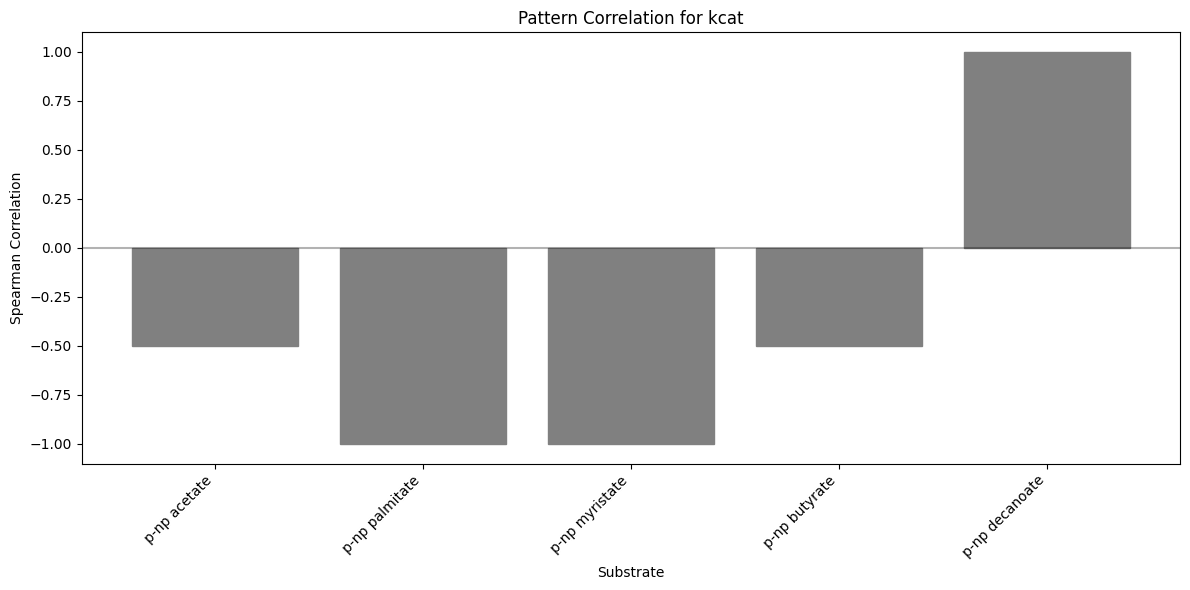

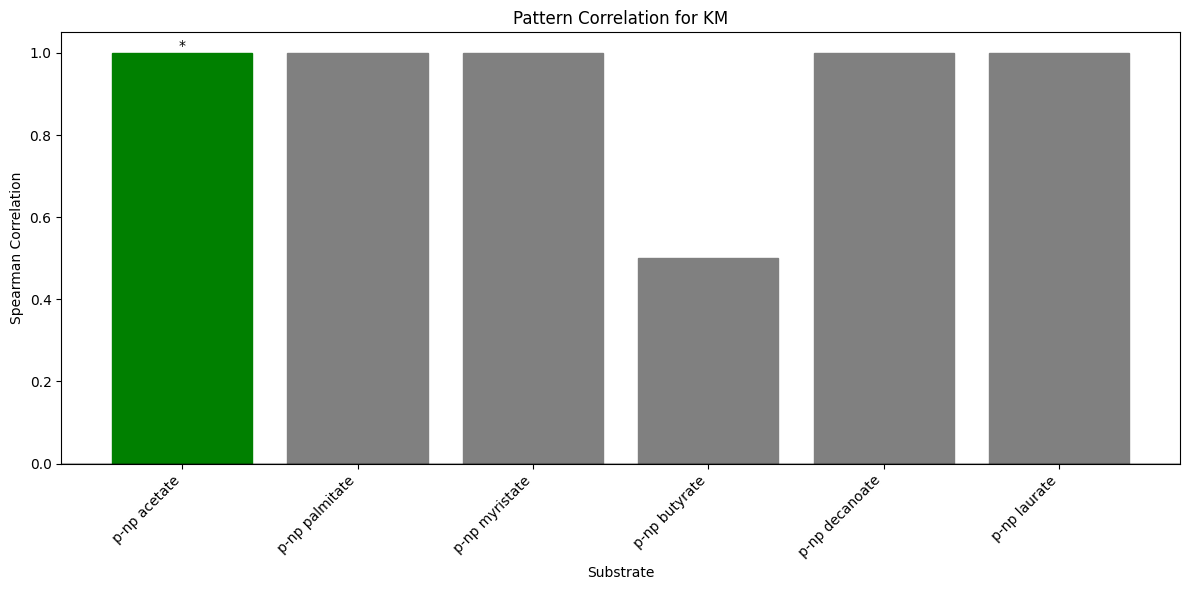

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re

def standardize_substrate_name(name):
    """
    Standardize substrate names between experimental and predicted data
    """
    # Convert to lowercase
    name = name.lower()
    
    # Remove carbon number annotations like (C2)
    name = re.sub(r'\s*\([cC]\d+\)\s*', '', name)
    
    # Standardize p-NP vs p-Nitrophenyl
    name = name.replace('p-nitrophenyl', 'p-np')
    name = name.replace('p-np', 'p-np')
    
    return name.strip()

def standardize_species_name(name):
    """
    Standardize species names between experimental and predicted data
    """
    # Convert to lowercase first to standardize
    name = name.lower()
    
    # Replace spaces with underscores
    name = name.replace(' ', '_')
    
    # Remove any special characters
    name = re.sub(r'[^a-z0-9_]', '', name)
    
    return name

def clean_experimental_data(file_path):
    # Read the TSV file
    df = pd.read_csv(file_path, sep='\t')
    print("\nExperimental data shape:", df.shape)
    print("Experimental data columns:", df.columns.tolist())
    
    # Replace 'NR' with NaN
    df = df.replace('NR', np.nan)
    
    # Clean species names
    df['Species'] = df['Species'].apply(standardize_species_name)
    
    # Clean substrate names
    df['Substrate'] = df['Substrate'].apply(standardize_substrate_name)
    
    print("\nAfter cleaning:")
    print("Unique species in experimental data:", df['Species'].unique())
    print("Unique substrates in experimental data:", df['Substrate'].unique())
    
    return df

def clean_predicted_data(file_path):
    # Read the TSV file
    df = pd.read_csv(file_path, sep='\t')
    print("\nPredicted data shape:", df.shape)
    print("Predicted data columns:", df.columns.tolist())
    
    # Clean species names
    df = df.rename(columns={'Enzyme': 'Species'})
    df['Species'] = df['Species'].apply(standardize_species_name)
    
    # Clean substrate names
    df['Substrate'] = df['Substrate'].apply(standardize_substrate_name)
    
    print("\nAfter cleaning:")
    print("Unique species in predicted data:", df['Species'].unique())
    print("Unique substrates in predicted data:", df['Substrate'].unique())
    
    return df

def match_and_analyze_patterns(exp_df, pred_df, parameter):
    """
    Analyze patterns for a given parameter (kcat or KM)
    Returns a dictionary of correlations per substrate
    """
    print(f"\nAnalyzing {parameter} patterns:")
    results = {}
    substrates = set(exp_df['Substrate'].unique()) & set(pred_df['Substrate'].unique())
    print(f"Found {len(substrates)} common substrates: {substrates}")
    
    for substrate in substrates:
        print(f"\nAnalyzing substrate: {substrate}")
        exp_subset = exp_df[exp_df['Substrate'] == substrate]
        pred_subset = pred_df[pred_df['Substrate'] == substrate]
        
        # Match species
        common_species = set(exp_subset['Species']) & set(pred_subset['Species'])
        print(f"Common species for {substrate}: {common_species}")
        
        if len(common_species) < 2:
            print(f"Skipping {substrate} - insufficient common species")
            continue
            
        exp_values = []
        pred_values = []
        valid_species = []
        
        for species in common_species:
            if parameter == 'kcat':
                exp_val = exp_subset[exp_subset['Species'] == species]['Kcat (s-1)'].iloc[0]
                pred_val = pred_subset[pred_subset['Species'] == species]['kcat (s⁻¹)'].iloc[0]
            else:  # KM
                exp_val = exp_subset[exp_subset['Species'] == species]['Km (mM)'].iloc[0]
                pred_val = pred_subset[pred_subset['Species'] == species]['KM (mM)'].iloc[0]
            
            print(f"{species}: exp={exp_val}, pred={pred_val}")
            
            if pd.notna(exp_val) and pd.notna(pred_val):
                exp_values.append(float(exp_val))
                pred_values.append(float(pred_val))
                valid_species.append(species)
        
        if len(exp_values) >= 2:
            correlation, p_value = stats.spearmanr(exp_values, pred_values)
            print(f"Correlation: {correlation:.3f}, p-value: {p_value:.3f}")
            results[substrate] = {
                'correlation': correlation,
                'p_value': p_value,
                'exp_values': exp_values,
                'pred_values': pred_values,
                'species': valid_species
            }
        else:
            print(f"Skipping {substrate} - insufficient valid data pairs")
    
    return results

def plot_correlations(results, parameter, output_file=None):
    """
    Create a visualization of the correlations
    """
    if not results:
        print(f"No valid results to plot for {parameter}")
        return
        
    plt.figure(figsize=(12, 6))
    
    substrates = list(results.keys())
    correlations = [results[s]['correlation'] for s in substrates]
    p_values = [results[s]['p_value'] for s in substrates]
    
    # Bar plot of correlations
    bars = plt.bar(substrates, correlations)
    
    # Color bars based on p-value
    for i, p in enumerate(p_values):
        if p < 0.05:
            bars[i].set_color('green')
        else:
            bars[i].set_color('gray')
            
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xlabel('Substrate')
    plt.ylabel('Spearman Correlation')
    plt.title(f'Pattern Correlation for {parameter}')
    plt.xticks(rotation=45, ha='right')
    
    # Add significance markers
    for i, p in enumerate(p_values):
        if p < 0.05:
            plt.text(i, correlations[i], '*', ha='center', va='bottom')
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file)
    plt.show()

def main(experimental_file, predicted_file):
    """
    Main function to run the analysis
    """
    try:
        # Clean data
        exp_df = clean_experimental_data(experimental_file)
        pred_df = clean_predicted_data(predicted_file)
        
        # Create output directory if it doesn't exist
        import os
        os.makedirs('results', exist_ok=True)
        
        # Analyze patterns for kcat and KM
        kcat_results = match_and_analyze_patterns(exp_df, pred_df, 'kcat')
        km_results = match_and_analyze_patterns(exp_df, pred_df, 'KM')
        
        # Plot results
        plot_correlations(kcat_results, 'kcat', 'results/kcat_correlations.png')
        plot_correlations(km_results, 'KM', 'results/km_correlations.png')
        
        # Save detailed results
        with open('results/analysis_results.txt', 'w') as f:
            f.write("kcat Pattern Analysis:\n")
            for substrate, results in kcat_results.items():
                f.write(f"\n{substrate}:\n")
                f.write(f"Correlation: {results['correlation']:.3f}\n")
                f.write(f"P-value: {results['p_value']:.3f}\n")
                f.write(f"Species analyzed: {', '.join(results['species'])}\n")
                f.write("Experimental values: " + ", ".join(f"{x:.2f}" for x in results['exp_values']) + "\n")
                f.write("Predicted values: " + ", ".join(f"{x:.2f}" for x in results['pred_values']) + "\n")
                
            f.write("\nKM Pattern Analysis:\n")
            for substrate, results in km_results.items():
                f.write(f"\n{substrate}:\n")
                f.write(f"Correlation: {results['correlation']:.3f}\n")
                f.write(f"P-value: {results['p_value']:.3f}\n")
                f.write(f"Species analyzed: {', '.join(results['species'])}\n")
                f.write("Experimental values: " + ", ".join(f"{x:.2f}" for x in results['exp_values']) + "\n")
                f.write("Predicted values: " + ", ".join(f"{x:.2f}" for x in results['pred_values']) + "\n")
                
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise



exp_data_path = "/home/robaina/Documents/NewAtlantis/ProteinRanker/data/lipase_review/kinetic_data.tsv"
pred_data_path = "/home/robaina/Documents/NewAtlantis/ProteinRanker/enzyme_kinetics.tsv"

main(exp_data_path, pred_data_path)